# Import libraries and load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
import gc
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from hyperopt import fmin, hp, tpe
import os



In [2]:
DATA_FOLDER = '../FutureSales/dataset/'

train_data      = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train_v2.csv'))
test_data       = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))

# Simple EDA

## Basic exploratory analysis

Some basic information about train and test data:

In [3]:
print(train_data.shape)
print(test_data.shape)
print(items.shape)
print(item_categories.shape)
print(shops.shape)

(2935849, 6)
(214200, 3)
(22170, 3)
(84, 2)
(60, 2)


In [4]:
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
test_data.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [7]:
train_data.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [8]:
train_data['item_cnt_day'].value_counts().sort_index().head(15)

-22.0          1
-16.0          1
-9.0           1
-6.0           2
-5.0           4
-4.0           3
-3.0          14
-2.0          78
-1.0        7252
 1.0     2629372
 2.0      194201
 3.0       47350
 4.0       19685
 5.0       10474
 6.0        6338
Name: item_cnt_day, dtype: int64

Take a look at the total sales for each month:

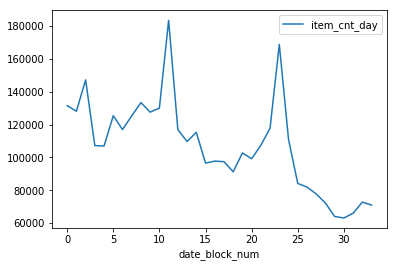

In [9]:
train_data[['date_block_num', 'item_cnt_day']].groupby('date_block_num').agg('sum').plot();

There is an obvious seasonal trend, especially in month 11 and 23 (December).

What's the correlation between the sales for each item in two adjacent months?

In [10]:
index_cols = ['shop_id','item_id','date_block_num']
sales=train_data[index_cols+[ 'item_cnt_day']].groupby(index_cols).agg('sum').reset_index()

In [11]:
sales_lag = sales.copy()
sales_lag['date_block_num']+=1
sales_lag.rename(columns={'item_cnt_day':'item_cnt_day_lag_1'},inplace=True)
sales = sales.merge(sales_lag,on=index_cols,how='left')

In [12]:
sales.dropna(inplace=True)
np.corrcoef(sales['item_cnt_day_lag_1'],sales['item_cnt_day'])[0][1]

0.7313478446098894

Roughly 0,73, a pretty high correlation coefficent. This implies the sales this month could be a good indicator for predicting the sales in the next month.

Furthermore, the average sales for one item among all the shops may also be useful. Think of applying mean-coding to the training data.

## Explore the structure of test data

Notice that we need to predict the monthly sales for the test set based on each `(shop_id, item_id)` pair. Have these pairs appeared in the training set? 

In [13]:
# add shop_item_pair feature to train and test
train_data['shop_item_pair'] = train_data[['shop_id', 'item_id']].apply(
    lambda x: (x['shop_id'], x['item_id']), axis=1)
test_data['shop_item_pair'] = test_data[['shop_id', 'item_id']].apply(
    lambda x: (x['shop_id'], x['item_id']), axis=1)

In [14]:
test_data['shop_id'].isin(train_data['shop_id'].drop_duplicates()).sum()

214200

All the shops in the test set have appeared in the training set.So Let's consider divide test set into three groups:

- Samples whose shop_item pairs have already existed in the training set
- Samples only item_id in the training set
- Samples that are totally new

In [15]:
# Select all shop_item_pair in the training set
shop_item_train_list = train_data['shop_item_pair'].unique()
item_train_list = train_data['item_id'].unique()

In [16]:
test_good_num = len(
    test_data[test_data['shop_item_pair'].isin(shop_item_train_list)])
test_item_old_num = len(test_data[(~test_data['shop_item_pair'].isin(
    shop_item_train_list)) & (test_data['item_id'].isin(item_train_list))])
test_new_num = len(test_data) - test_good_num-test_item_old_num
print('# shop_item pair in the train: {0}'.format(test_good_num))
print('# item_id in the train: {0}'.format(test_item_old_num))
print('# new: {0}'.format(test_new_num))

# shop_item pair in the train: 111404
# item_id in the train: 87550
# new: 15246


Would these groups have different distributions of sales? Let's examine similar patterns in the data of month 33:

First, create val_data dataframe;

In [17]:
from itertools import product
val_data = train_data[train_data['date_block_num'] == 33]
# fill in those shop_item pairs that didn't have sales on month 33
val_shops = val_data['shop_id'].unique()
val_items = val_data['item_id'].unique()
grid = pd.DataFrame(np.array(
    list(product(*[val_shops, val_items, [33]]))), columns=index_cols)
gb = val_data[index_cols+['item_cnt_day']
              ].groupby(index_cols, as_index=False).agg('sum')
# join aggregated data to the grid
val_all_data = pd.merge(grid, gb, how='left', on=index_cols)
# fill NA values for item_cnt
val_all_data['item_cnt_day'].fillna(0, inplace=True)
val_all_data['shop_item_pair'] = val_all_data[['shop_id', 'item_id']].apply(
    lambda x: (x['shop_id'], x['item_id']), axis=1)

Then apply the same method to val_data:

In [18]:
train_drop_val = train_data[train_data['date_block_num']<33]
shop_item_train_list = train_drop_val['shop_item_pair'].unique()
item_train_list = train_drop_val['item_id'].unique()

In [19]:
val_good = val_all_data[val_all_data['shop_item_pair'].isin(shop_item_train_list)]
val_item_old = val_all_data[(~val_all_data['shop_item_pair'].isin(
    shop_item_train_list)) & (val_all_data['item_id'].isin(item_train_list))]
val_new = val_all_data[~(val_all_data['item_id'].isin(item_train_list))]
print('# shop_item pair in the train: {0}'.format(len(val_good)))
print('# item_id in the train: {0}'.format(len(val_item_old)))
print('# new: {0}'.format(len(val_new)))

# shop_item pair in the train: 117057
# item_id in the train: 100215
# new: 20900


Next, Let's take a look at the distributions for the target in the tree types:

In [20]:
# clip target
val_good['item_cnt_day'].clip(0,20,inplace=True)
val_item_old['item_cnt_day'].clip(0,20,inplace=True)
val_new['item_cnt_day'].clip(0,20,inplace=True)

E:\Anaconda3\lib\site-packages\pandas\core\generic.py:6316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)


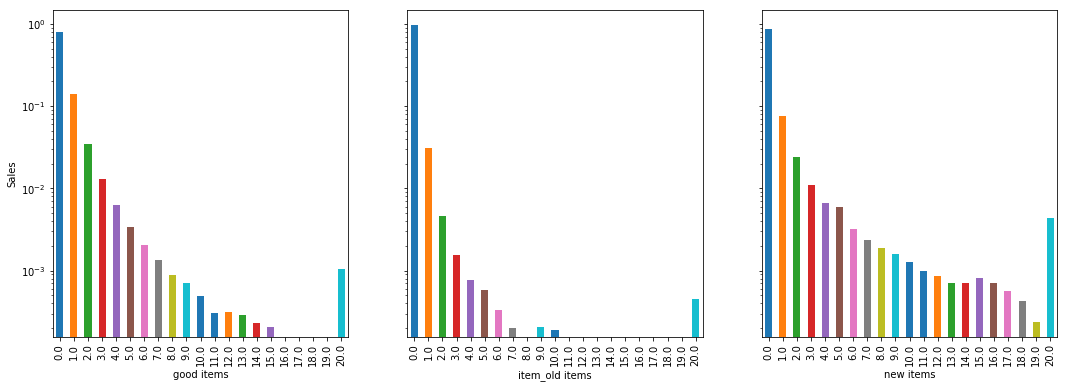

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=3,sharey=True, figsize=(18, 6))

for i, df, name in zip(range(3), [val_good, val_item_old, val_new], ['good', 'item_old', 'new']):    
    plot_data = df['item_cnt_day'].value_counts(normalize=True).sort_index()
    ax = plot_data.plot(kind='bar', ax=axes[i],logy=True)
    ax.set_xlabel(name+' items')
    ax.set_ylabel('Sales')

The above figures show that the three types have different distribution for target value. For item_old items, there is a very high probability for zero sales. For new items, when sales happen, the amount of sales would be relatively higher. So the difference in these types may be a good indicator for prediction. Actually, this factor contributes a lot to my final solution.

# Creat complete training dataset

Now let's start feature engineering. Fisrt I fill in the missing samples which have zero sales:

In [22]:
# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in tqdm_notebook(train_data['date_block_num'].unique()):
    cur_shops = train_data[train_data['date_block_num']==block_num]['shop_id'].unique()
    cur_items = train_data[train_data['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [23]:
#get aggregated values for (shop_id, item_id, month)
gb = train_data.groupby(index_cols,as_index=False).agg({'item_cnt_day':'sum','item_price':'mean'})

#join aggregated data to the grid
all_data = pd.merge(grid,gb,how='left',on=index_cols)
#fill NA values for item_cnt
all_data['item_cnt_day'].fillna(0,inplace=True)
#sort the data
all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

In [24]:
# merge item_category into data
all_data = pd.merge(all_data, items, on='item_id', how='left')
all_data.rename(columns={'item_cnt_day': 'item_cnt'}, inplace=True)

In [25]:
# downcast data to save memory
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float16`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float16)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

all_data = downcast_dtypes(all_data)

In [26]:
del grid, gb
gc.collect();

In [27]:
all_data.head()

,shop_id,item_id,date_block_num,item_cnt,item_price,item_name,item_category_id
0,0,19,0,0.0,NaN,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40
1,0,27,0,0.0,NaN,"007 Legends [PS3, русская версия]",19
2,0,28,0,0.0,NaN,"007 Legends [PС, Jewel, русская версия]",30
3,0,29,0,0.0,NaN,"007 Legends [Xbox 360, русская версия]",23
4,0,32,0,6.0,221.0,1+1,40


# Mean Encoding

In [28]:
def mean_enc(df_, enc_cols, enc_list):
    gb_list = []
    df = df_.copy()
    for type_id in tqdm_notebook(enc_cols):
        if type_id == None:
            for column_id, aggregator, aggtype in enc_list:
                gb = df.groupby(['date_block_num']).agg(
                    aggregator).reset_index()[[column_id, 'date_block_num']]
                gb.columns = ['{0}_{1}_{2}'.format(
                    'date', aggtype, column_id), 'date_block_num']
                df = pd.merge(df, gb, on=[
                    'date_block_num'], how='left')
                gb_list.append(gb)
        elif type(type_id) == str:
            for column_id, aggregator, aggtype in enc_list:
                gb = df.groupby([type_id, 'date_block_num']).agg(
                    aggregator).reset_index()[[column_id, type_id, 'date_block_num']]
                gb.columns = ['{0}_{1}_{2}'.format(
                    type_id, aggtype, column_id), type_id, 'date_block_num']
                df = pd.merge(df, gb, on=[
                    'date_block_num', type_id], how='left')
                gb_list.append(gb)
        else:
            for column_id, aggregator, aggtype in enc_list:
                gb = df.groupby([type_id[0], type_id[1], 'date_block_num']).agg(
                    aggregator).reset_index()[[column_id, type_id[0], type_id[1], 'date_block_num']]
                gb.columns = ['{0}_{1}_{2}_{3}'.format(
                    type_id[0], type_id[1], aggtype, column_id), type_id[0], type_id[1], 'date_block_num']
                df = pd.merge(df, gb, on=[
                    'date_block_num', type_id[0], type_id[1]], how='left')
                gb_list.append(gb)
    return df, gb_list

In [29]:
enc_cols = ['item_id', 'shop_id', 'item_category_id',['shop_id', 'item_category_id']]
enc_list = [('item_cnt', np.sum, 'sum'), ('item_price', np.mean, 'avg')]
all_data_enc, gb_list = mean_enc(all_data, enc_cols, enc_list)

In [30]:
all_data_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10913850 entries, 0 to 10913849
Data columns (total 15 columns):
shop_id                                    int32
item_id                                    int32
date_block_num                             int32
item_cnt                                   float16
item_price                                 float16
item_name                                  object
item_category_id                           int32
item_id_sum_item_cnt                       float16
item_id_avg_item_price                     float16
shop_id_sum_item_cnt                       float16
shop_id_avg_item_price                     float16
item_category_id_sum_item_cnt              float16
item_category_id_avg_item_price            float16
shop_id_item_category_id_sum_item_cnt      float16
shop_id_item_category_id_avg_item_price    float16
dtypes: float16(10), int32(4), object(1)
memory usage: 541.2+ MB


In [31]:
del all_data
gc.collect();

# make lag features

In [32]:
test_data = downcast_dtypes(test_data)

test_data['date_block_num'] = 34

test = test_data.merge(items, on='item_id', how='left')
# combine train and test data together
traintest = pd.concat([all_data_enc, test],sort=False)

In [33]:
traintest.drop(['item_name'], axis=1, inplace=True)

In [34]:
lags = [1, 2, 3, 12]
for lag in tqdm_notebook(lags):
    lag_df = traintest[index_cols + ['item_cnt']]
    lag_df.loc[:, 'date_block_num'] += lag
    lag_df = lag_df.rename(columns={'item_cnt': 'item_cnt'+'_lag_'+str(lag)})
    traintest = traintest.merge(
        lag_df, on=index_cols, how='left')

E:\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [35]:
del all_data_enc;
gc.collect()

42

In [36]:
def make_lag_feat(df_, lag_feat, lags, gb_list):
    df = df_.copy()
    for gb_, feat in tqdm_notebook(zip(gb_list, lag_feat)):
        for lag in tqdm_notebook(lags):
            gb = gb_.copy()
            gb.loc[:, 'date_block_num'] += lag
            gb = gb.rename(columns={feat: feat+'_lag_'+str(lag)})
            df = df.merge(gb, on=list(gb.columns[1:]), how='left')
    return df

In [37]:
lag_features = list(traintest.columns[6:14])
lags = [1, 2, 3, 12]

traintest = make_lag_feat(traintest, lag_features, lags, gb_list)

In [38]:
# fill in these NA values for item_id related features
item_id_feat = list(traintest.columns[15:23])
for feat in item_id_feat:
    traintest[feat].fillna(0, inplace=True)

# Add trend features

Add a feature to determine whether a shop starts to open this month:

In [39]:
shop_open_date = traintest[['shop_id', 'date_block_num']].groupby('shop_id').transform('min')

In [40]:
traintest['is_new_open'] = (traintest['date_block_num'] == shop_open_date['date_block_num']).map(lambda x: 1 if x else 0)

In [41]:
# throw away the data in the first 12 months
traintest = traintest[traintest['date_block_num']>=12]

In [42]:
traintest.head()

,shop_id,item_id,date_block_num,item_cnt,item_price,item_category_id,item_id_sum_item_cnt,item_id_avg_item_price,shop_id_sum_item_cnt,shop_id_avg_item_price,...,item_category_id_avg_item_price_lag_12,shop_id_item_category_id_sum_item_cnt_lag_1,shop_id_item_category_id_sum_item_cnt_lag_2,shop_id_item_category_id_sum_item_cnt_lag_3,shop_id_item_category_id_sum_item_cnt_lag_12,shop_id_item_category_id_avg_item_price_lag_1,shop_id_item_category_id_avg_item_price_lag_2,shop_id_item_category_id_avg_item_price_lag_3,shop_id_item_category_id_avg_item_price_lag_12,is_new_open
4488756,2,27,12,0.0,NaN,19,1.0,998.000,890.0,1096.0,...,1475.000,281.0,140.0,191.0,114.0,1387.000,1669.0,1401.000,1524.000,0
4488757,2,30,12,0.0,NaN,40,58.0,169.000,890.0,1096.0,...,213.875,93.0,49.0,44.0,175.0,242.125,253.0,239.875,205.875,0
4488758,2,31,12,0.0,NaN,37,15.0,499.000,890.0,1096.0,...,457.000,55.0,42.0,29.0,52.0,431.750,429.0,527.000,502.750,0
4488759,2,32,12,1.0,119.0,40,84.0,140.875,890.0,1096.0,...,213.875,93.0,49.0,44.0,175.0,242.125,253.0,239.875,205.875,0
4488760,2,33,12,1.0,199.0,37,42.0,196.250,890.0,1096.0,...,457.000,55.0,42.0,29.0,52.0,431.750,429.0,527.000,502.750,0


Add features price changing rate and the total revenue last month for each shop:

In [43]:
for type in tqdm_notebook(['item_id', 'item_category_id', 'shop_id_item_category_id']):
    traintest[type+'_delta_price_lag_1'] = traintest[type+'_avg_item_price_lag_1'] / \
        traintest[type+'_avg_item_price_lag_2'] - 1

In [44]:
traintest['shop_id_revenue_lag_1'] = traintest['shop_id_avg_item_price_lag_1'].astype('float32') * \
    traintest['shop_id_sum_item_cnt_lag_1'].astype('float32')

Add the feature that whether the sample is in December:

In [45]:
traintest['month_11'] = traintest['date_block_num'].apply(lambda x: 1 if x%12==11 else 0)

In [46]:
shop_price_feat=[]
for feat in traintest.columns:
    if 'shop_id' in feat and 'avg_item_price_lag' in feat:
        shop_price_feat.append(feat)

In [47]:
cols_to_drop = list(
    traintest.columns[6:14]) + shop_price_feat + ['item_price']

In [48]:
cols_to_drop

['item_id_sum_item_cnt',
 'item_id_avg_item_price',
 'shop_id_sum_item_cnt',
 'shop_id_avg_item_price',
 'item_category_id_sum_item_cnt',
 'item_category_id_avg_item_price',
 'shop_id_item_category_id_sum_item_cnt',
 'shop_id_item_category_id_avg_item_price',
 'shop_id_avg_item_price_lag_1',
 'shop_id_avg_item_price_lag_2',
 'shop_id_avg_item_price_lag_3',
 'shop_id_avg_item_price_lag_12',
 'shop_id_item_category_id_avg_item_price_lag_1',
 'shop_id_item_category_id_avg_item_price_lag_2',
 'shop_id_item_category_id_avg_item_price_lag_3',
 'shop_id_item_category_id_avg_item_price_lag_12',
 'item_price']

In [49]:
traintest = traintest.drop(cols_to_drop, axis=1)

In [50]:
traintest = downcast_dtypes(traintest)

# Add magic feature

For each sample, determine whether it is an appeared shop_item pair or a totally new item. This feature helped me reduce RMSE by around 0.4.

In [51]:
traintest['shop_item_pair'] = traintest[['shop_id', 'item_id']].apply(
    lambda x: (x['shop_id'], x['item_id']), axis=1)

In [52]:
def is_good(df, date):
    shop_item_list = train_data.loc[train_data['date_block_num']
                                    < date, 'shop_item_pair'].drop_duplicates()
    return df['shop_item_pair'].isin(shop_item_list)

In [53]:
for date in tqdm_notebook(range(12, 35)):
    traintest.loc[traintest['date_block_num'] == date, 'is_good'] = is_good(
        traintest[traintest['date_block_num'] == date], date).apply(lambda x: 1 if x else 0)

In [54]:
def is_new(df, date):
    item_list = train_data.loc[train_data['date_block_num']<date,'item_id'].drop_duplicates()
    return (df['item_id'].isin(item_list)).apply(lambda x: 0 if x else 1)

In [55]:
for date in tqdm_notebook(range(12, 35)):
    traintest.loc[traintest['date_block_num'] == date, 'is_new'] = is_new(
        traintest[traintest['date_block_num'] == date], date)

In [56]:
traintest.loc[traintest['date_block_num'] == 33, 'is_new'].sum()

20900.0

In [57]:
traintest.drop('shop_item_pair', axis=1, inplace=True)

In [58]:
traintest = downcast_dtypes(traintest)

In [69]:
traintest.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt', 'item_category_id',
       'ID', 'item_cnt_lag_1', 'item_cnt_lag_2', 'item_cnt_lag_3',
       'item_cnt_lag_12', 'item_id_sum_item_cnt_lag_1',
       'item_id_sum_item_cnt_lag_2', 'item_id_sum_item_cnt_lag_3',
       'item_id_sum_item_cnt_lag_12', 'item_id_avg_item_price_lag_1',
       'item_id_avg_item_price_lag_2', 'item_id_avg_item_price_lag_3',
       'item_id_avg_item_price_lag_12', 'shop_id_sum_item_cnt_lag_1',
       'shop_id_sum_item_cnt_lag_2', 'shop_id_sum_item_cnt_lag_3',
       'shop_id_sum_item_cnt_lag_12', 'item_category_id_sum_item_cnt_lag_1',
       'item_category_id_sum_item_cnt_lag_2',
       'item_category_id_sum_item_cnt_lag_3',
       'item_category_id_sum_item_cnt_lag_12',
       'item_category_id_avg_item_price_lag_1',
       'item_category_id_avg_item_price_lag_2',
       'item_category_id_avg_item_price_lag_3',
       'item_category_id_avg_item_price_lag_12',
       'shop_id_item_category_id_sum_item_cn

In [59]:
# h5 = pd.HDFStore('../FutureSales/traintest_final.h5','w')
# h5['data'] = traintest
# h5.close()

# Train a model

In [60]:
train_val_df = traintest[traintest['date_block_num']<=33]
test = traintest[traintest['date_block_num']==34]
train_val_df.drop('ID', axis=1, inplace=True)
test.drop('item_cnt', axis=1, inplace=True)

E:\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [61]:
X_train = train_val_df[train_val_df['date_block_num'] < 33].drop(
    'item_cnt', axis=1)
y_train = train_val_df.loc[train_val_df['date_block_num']
                           < 33, 'item_cnt']
y_train.clip(0, 20, inplace=True)
X_val = train_val_df[train_val_df['date_block_num'] == 33].drop(
    'item_cnt', axis=1)
y_val = train_val_df.loc[train_val_df['date_block_num']
                           == 33, 'item_cnt']
y_val.clip(0, 20, inplace=True)

Use hyperopt to find the best hyperparameter:

In [62]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
def objective(params):
    params['num_leaves'] = int(params['num_leaves']),
    model = lgb.train(params,
                      lgb_train,
                      num_boost_round=1000,
                      valid_sets=lgb_eval,
                      early_stopping_rounds=50)
    y_val_pred = model.predict(X_val)
    y_val_pred = y_val_pred.clip(0, 20)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    return rmse


space = {
    'max_depth': hp.choice('max_depth', np.arange(5, 15, 1, dtype=int)),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'min_data_in_leaf': hp.choice('min_data_in_leaf', np.arange(5, 30, 1, dtype=int)),
    'learning_rate': hp.quniform('learning_rate', 0.02, 0.3, 0.02),
    'seed': 0,
    'objective': 'regression',
    'metric': 'rmse',
    'verbose': 0
}

The tuning process is too long, so I load the trained model instead of running the following cell:

In [63]:
# best = fmin(fn=objective,
#             space=space,
#             algo=tpe.suggest,
#             max_evals=20)
# print("The best hyperparameters are: ")
# print(best)

In [64]:
model = joblib.load('model_lgb.pkl')
model.params

{'max_depth': 9,
 'bagging_fraction': 0.6519025524137463,
 'colsample_bytree': 0.4024851089341827,
 'num_leaves': 120,
 'min_data_in_leaf': 23,
 'learning_rate': 0.02,
 'seed': 0,
 'objective': 'regression',
 'metric': 'rmse',
 'verbose': 0}

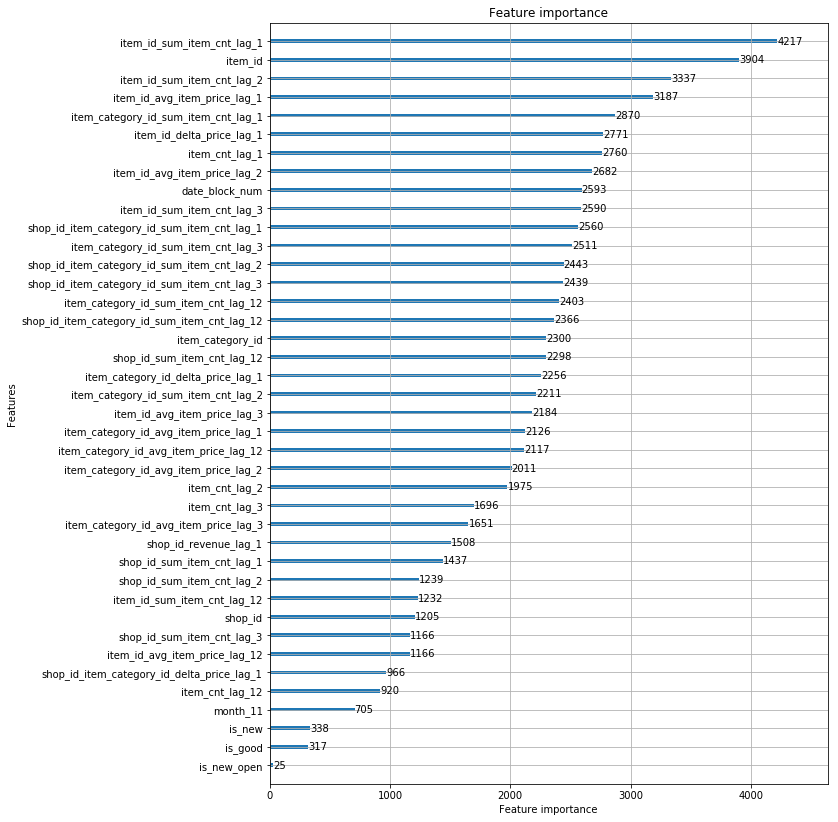

In [65]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return lgb.plot_importance(booster=booster, ax=ax)
plot_features(model,(10,14))

Make preditions:

In [66]:
y_test_pred = model.predict(test.drop('ID', axis=1))
y_test_pred = y_test_pred.clip(0, 20)

In [67]:
sub_df = pd.DataFrame({'ID':pd.Series(range(0,214200)),'item_cnt_month': y_test_pred })

This is the prediction I got:

In [68]:
sub_df.head(10)

,ID,item_cnt_month
0,0,0.628521
1,1,1.219965
2,2,1.123938
3,3,0.439114
4,4,2.897255
5,5,0.541597
6,6,0.799661
7,7,0.137542
8,8,0.760920
9,9,0.549273
